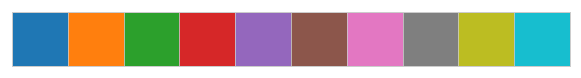

In [1]:
import numpy as np
import pandas as pd
import json
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from scipy.sparse import csr_matrix, hstack
from scipy.stats import probplot
import pickle
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
import time
from html.parser import HTMLParser
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import PorterStemmer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, StratifiedKFold
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn import decomposition
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import Ridge



color = sns.color_palette()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.palplot(color)

import os
PATH = "../../data"

In [2]:
def read_json_line(line=None):
    result = None
    try:
        result = json.loads(line)
    except Exception as e:
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)
        return read_json_line(line=new_line)
    return result


class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [3]:
def extract_features(path_to_data):

    content_list = []
    published_list = []
    title_list = []
    author_list = []
    domain_list = []
    tags_list = []
    url_list = []

    with open(path_to_data, encoding='utf-8') as inp_json_file:
        for line in inp_json_file:
            json_data = read_json_line(line)
#             content = json_data['content'].replace('\n', ' ').replace('\r', ' ') # ORIG
            content = json_data['content'].replace('\n', ' \n ').replace('\r', ' \n ') # keep newline
            content_no_html_tags = strip_tags(content)
            content_list.append(content_no_html_tags)
            published = json_data['published']['$date']
            published_list.append(published)
            title = json_data['meta_tags']['title'].split('\u2013')[0].strip() #'Medium Terms of Service – Medium Policy – Medium'
            title_list.append(title)
            author = json_data['meta_tags']['author'].strip()
            author_list.append(author)
            domain = json_data['domain']
            domain_list.append(domain)
            url = json_data['url']
            url_list.append(url)

            tags_str = []
            soup = BeautifulSoup(content, 'lxml')
            try:
                tag_block = soup.find('ul', class_='tags')
                tags = tag_block.find_all('a')
                for tag in tags:
                    tags_str.append(tag.text.translate({ord(' '):None, ord('-'):None}))
                tags = ' '.join(tags_str)
            except Exception:
                tags = 'None'
            tags_list.append(tags)

    return content_list, published_list, title_list, author_list, domain_list, tags_list, url_list


# ## 1.2. Data extraction

# [ ]:


content_list, published_list, title_list, author_list, domain_list, tags_list, url_list = \
    extract_features(os.path.join(PATH, 'train.json'))

train = pd.DataFrame()
train['content'] = content_list
train['published'] = pd.to_datetime(published_list, format='%Y-%m-%dT%H:%M:%S.%fZ')
train['title'] = title_list
train['author'] = author_list
train['domain'] = domain_list
train['tags'] = tags_list
# train['length'] = train['content'].apply(len)
train['url'] = url_list

content_list, published_list, title_list, author_list, domain_list, tags_list, url_list = \
    extract_features(os.path.join(PATH, 'test.json'))

test = pd.DataFrame()
test['content'] = content_list
test['published'] = pd.to_datetime(published_list, format='%Y-%m-%dT%H:%M:%S.%fZ')
test['title'] = title_list
test['author'] = author_list
test['domain'] = domain_list
test['tags'] = tags_list
# test['length'] = test['content'].apply(len)
test['url'] = url_list


# [ ]:


del content_list, published_list, title_list, author_list, domain_list, tags_list, url_list
gc.collect()


# [ ]:


train['target'] = pd.read_csv(os.path.join(
        PATH,
        'train_log1p_recommends.csv'),
    index_col='id').values


# [ ]:


train.tail()


# [ ]:


train.describe()


train.to_csv("mediumPopularity.csv.gz", index=False, compression="gzip")
test.to_csv("mediumPopularity_test.csv.gz", index=False, compression="gzip")

In [4]:
train['week_day'] = train['published'].apply(lambda x: x.dayofweek)
train['year'] = train['published'].apply(lambda x: x.year)
train['month'] = train['published'].apply(lambda x: x.month)
train['hour'] = train['published'].apply(lambda x: x.hour)
#train['number_of_tags'] = train['tags'].apply(lambda x: len(x.split()))

test['week_day'] = test['published'].apply(lambda x: x.dayofweek)
test['year'] = test['published'].apply(lambda x: x.year)
test['month'] = test['published'].apply(lambda x: x.month)
test['hour'] = test['published'].apply(lambda x: x.hour)
#test['number_of_tags'] = test['tags'].apply(lambda x: len(x.split()))

In [5]:
top = train.sort_values(by='target', ascending=False).reset_index(drop=True)
print(top.loc[0, 'url'])
print(top.loc[1, 'url'])

https://medium.com/personal-growth/13-things-you-need-to-give-up-if-you-want-to-be-successful-44b5b9b06a26
https://medium.com/@dinachka82/about-your-poem-1f26a7585a6f


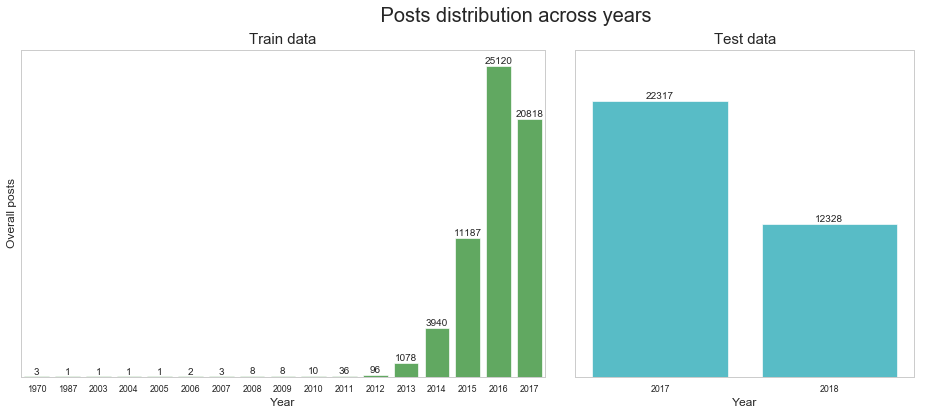

In [6]:
plt.figure(figsize=(16,6))
plt.suptitle("                       Posts distribution across years",fontsize=20)

ax1 = plt.subplot2grid((1,5),(0,0), colspan=3)
ax1 = sns.countplot(x='year', data=train, alpha=0.8, color=color[2])
plt.ylabel('Overall posts', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.title('Train data', fontsize=15)
plt.grid(False)

for p in ax1.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax1.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')
    
ax2 = plt.subplot2grid((1,5),(0,3), colspan=2, sharey=ax1)
ax2 = sns.countplot(x='year', data=test, alpha=0.8, color=color[9])
plt.xlabel('Year', fontsize=12)
plt.title('Test data', fontsize=15)
plt.yticks([])
plt.ylabel('')

for p in ax2.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax2.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

In [11]:
train = train[train.year >= 2015]

In [12]:
train_df = train
test_df = test

all_zero_mae = 4.33328

In [13]:
def write_submission_file(prediction,
                          filename,
                          path_to_sample=os.path.join(
                                  PATH,
                                  'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')

    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [14]:
# Special transformer to save output shape
class ShapeSaver(BaseEstimator, TransformerMixin):
    def transform(self, X):
        self.shape = X.shape
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [15]:
# Run preprocessing on full data
x_train_new = train_df.iloc[:, :-1]
x_test_new = test_df.iloc[:, :].copy()
experiments = {}

with open('medium_experiments.pickle', 'rb') as f:
    experiments = pickle.load(f)

In [16]:
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [17]:
def extract_content_as_string(X):
    return X['content']


def extract_content_length(X):
    return pd.DataFrame(X['content'].str.len())


def extract_author_as_string(X):
    return X['author']


def extract_tags_as_string(X):
    return X['tags']


def extract_title_as_string(X):
    return X['title']

def extract_domain_as_string(X):
    return X['domain']


def feature_weekday(X):
    return X['week_day']


def feature_hour(X):
    return X['hour']


def feature_month(X):
    return X['month']


# yearfeature from A4
def feature_year(X):
    return X['year']


# Month Q
def feature_month_q1(X):
    return pd.DataFrame(X['published'].dt.month.isin([1, 2, 3]))


# Month Q
def feature_month_q2(X):
    return pd.DataFrame(X['published'].dt.month.isin([4, 5, 6]))


# Month Q
def feature_month_q3(X):
    return pd.DataFrame(X['published'].dt.month.isin([7, 8, 9]))


# Month Q
def feature_month_q4(X):
    return pd.DataFrame(X['published'].dt.month.isin([10, 11, 12]))


def stem_tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems


class StemmedCountVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])


class TfidfLeammatizerVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfLeammatizerVectorizer, self).build_analyzer()
        return lambda doc: ([wordnet_lemmatizer.lemmatize(w) for w in analyzer(doc)])

In [18]:
# --------------------------------------------------------------------------
transform_pipeline = Pipeline([
    ('features', FeatureUnion([
        # List of features goes here:
        ('author_tfidf', Pipeline([
            ('extract', FunctionTransformer(extract_author_as_string, validate=False)),
            ('count', TfidfVectorizer(ngram_range=(2, 2), max_features=10000)),
#            ("tfidf", TfidfTransformer()),
            ('shape', ShapeSaver())
        ])),

        ('domain_tfidf', Pipeline([
            ('extract', FunctionTransformer(extract_domain_as_string, validate=False)),
            ('count', TfidfVectorizer(max_features=10000)),
#            ("tfidf", TfidfTransformer()),
            ('shape', ShapeSaver())
        ])),

#        ('weekday_cat', Pipeline([
#            ('extract', FunctionTransformer(feature_weekday, validate=False)),
#            ('ohe', OneHotEncoder()),
#            ('shape', ShapeSaver())
#        ])),

#        ('month_cat', Pipeline([
#            ('extract', FunctionTransformer(feature_month, validate=False)),
#            ('ohe', OneHotEncoder()),
#            ('shape', ShapeSaver())
#         ])),

#        ('hour_val', Pipeline([
#            ('extract', FunctionTransformer(feature_hour, validate=False)),
##            ('scale', StandardScaler()),
#            ('ohe', OneHotEncoder()),
#            ('shape', ShapeSaver())
#         ])),

#        ('mon_q1', Pipeline([
#            ('extract', FunctionTransformer(feature_month_q1, validate=False)),
#            ('shape', ShapeSaver())
#         ])),
#        ('mon_q2', Pipeline([
#            ('extract', FunctionTransformer(feature_month_q2, validate=False)),
#            ('shape', ShapeSaver())
#         ])),
#        ('mon_q3', Pipeline([
#            ('extract', FunctionTransformer(feature_month_q3, validate=False)),
#            ('shape', ShapeSaver())
#         ])),
#        ('mon_q4', Pipeline([
#            ('extract', FunctionTransformer(feature_month_q4, validate=False)),
#            ('shape', ShapeSaver())
#         ])),

#        ('year', Pipeline([
#            ('extract', FunctionTransformer(feature_year, validate=False)),
#            ('ohe', OneHotEncoder()),
#            ('shape', ShapeSaver())
#         ])),

#        ('tags_tfidf', Pipeline([
#            ('extract', FunctionTransformer(extract_tags_as_string, validate=False)),
#            ('count', TfidfVectorizer(max_features=10000)),
##            ("tfidf", TfidfTransformer()),
#            ('shape', ShapeSaver())
#        ])),
#
#        ('title_tfidf', Pipeline([
#            ('extract', FunctionTransformer(extract_title_as_string, validate=False)),
#            ('count', TfidfVectorizer(max_features=10000)),
##            ("tfidf", TfidfTransformer()),
#            ('shape', ShapeSaver())
#        ])),

#        ('content_length', Pipeline([
#            ('extract', FunctionTransformer(extract_content_length, validate=False)),
#            ('scale', StandardScaler()),
#            ('shape', ShapeSaver())
#        ])),

#        ('content_tfidf', Pipeline([
#            ('extract', FunctionTransformer(extract_content_as_string, validate=False)),
#            ('count', TfidfVectorizer(max_features=50000)),
##            ("tfidf", TfidfTransformer()),
#            ('shape', ShapeSaver())
#        ])),

#    ('content13_tfidf', Pipeline([
#            ('extract', FunctionTransformer(extract_content_as_string, validate=False)),
#            ('count', TfidfVectorizer(ngram_range=(1, 3), max_features=50000)),
##            ("tfidf", TfidfTransformer()),
#            ('shape', ShapeSaver())
#        ])),

#        ('content_stem_tfidf', Pipeline([
#            ('extract', FunctionTransformer(extract_content_as_string, validate=False)),
#            ('count', StemmedCountVectorizer(ngram_range=(1, 3), max_features=50000)),
##            ("tfidf", TfidfTransformer()),
#            ('shape', ShapeSaver())
#        ])),

        ('content_lemma_tfidf', Pipeline([
            ('extract', FunctionTransformer(extract_content_as_string, validate=False)),
            ('count', TfidfLeammatizerVectorizer(
                    max_features=50000,
                    strip_accents='unicode',
                    min_df=5,
                    sublinear_tf=True
                    )),
#            ('tsvd1',
#                  decomposition.TruncatedSVD(
#                          n_components=200,
#                          n_iter=25,
#                          random_state=17)),
# #            ("tfidf", TfidfTransformer()),
#             ('shape', ShapeSaver())
        ])),

#        ('content_stem_tokenize_tfidf', Pipeline([
#            ('extract', FunctionTransformer(extract_content_as_string, validate=False)),
#            ('count', TfidfVectorizer(tokenizer=stem_tokenize,
#                                             max_features=50000)),
##            ("tfidf", TfidfTransformer()),
#            ('shape', ShapeSaver())
##        ])),
        # Add more features here :)
        # ...
    ]))
])

In [19]:
# --------------------------------------------------------------------------
def full_fit(clf, Xtrain, ytrain, Xtest):
    clf.fit(X_train_new, src_to_pred(y_train_new))
    clf_test_pred = pred_to_src(clf.predict(Xtest))
    return clf, clf_test_pred

# --------------------------------------------------------------------------
def full_lgm_fit(clf, Xtrain, ytrain, Xtest):
    lgb_x_train_part = lgb.Dataset(
            Xtrain.astype(np.float32),
            label=src_to_pred(ytrain))

    bst_lgb = lgb.train(clf.params,
                        lgb_x_train_part
                        )

    lgb_pred = pred_to_src(
            bst_lgb.predict(
                    Xtest.astype(np.float32),
                    num_iteration = bst_lgb.best_iteration))

    return bst_lgb, lgb_pred

# --------------------------------------------------------------------------
def full_lgm_fit_cv(clf, Xtrain, ytrain, Xtest):

    bst_lgb = clf.fit(Xtrain.astype(np.float32), src_to_pred(ytrain))

    lgb_pred = pred_to_src(
            bst_lgb.predict(
                    Xtest.astype(np.float32),
                    num_iteration = bst_lgb.best_iteration))

    return bst_lgb, lgb_pred

# --------------------------------------------------------------------------
def train_lgm(Xtrain, ytrain, Xvalid, yvalid, Xtest):
    experiment_name = 'train_lgm' + time.strftime("%d_%m_%Y_%H_%M_%S")
    experiment = {}
    experiment['time'] = experiment_name

    print(Xtrain.shape)

    experiment['transformed_train_df_shape'] = Xtrain.shape
    experiment['features'] = [
            v[0] for v in transform_pipeline.steps[0][1].transformer_list]

    lgb_x_train_part = lgb.Dataset(
            Xtrain.astype(np.float32),
            label=src_to_pred(ytrain))

    lgb_x_valid = lgb.Dataset(
            Xvalid.astype(np.float32),
            label=src_to_pred(yvalid))

    param = {'num_leaves': 31,
             'num_trees': 500,
             'objective': 'mean_absolute_error',
             'metric': 'mae'}

    num_round = 100
    bst_lgb = lgb.train(param,
                        lgb_x_train_part,
                        num_round,
                        valid_sets = [lgb_x_valid],
                        early_stopping_rounds=20)

    lgb_pred = pred_to_src(
            bst_lgb.predict(
                    Xvalid.astype(np.float32),
                    num_iteration = bst_lgb.best_iteration))

    lgb_valid_mae = mean_absolute_error(yvalid, lgb_pred)
    print('LGM valid mae: {}'.format(lgb_valid_mae))

    experiment['clf'] = 'lgm'
    experiment['valid_mae'] = lgb_valid_mae
    experiment['np.expm1_valid_mae'] = pred_to_src(lgb_valid_mae)

    lgb_test_pred = pred_to_src(bst_lgb.predict(Xtest.astype(np.float32)))

    return bst_lgb, lgb_pred, experiment, lgb_test_pred

# --------------------------------------------------------------------------
def train_clf(clf, Xtrain, ytrain, Xvalid, yvalid, Xtest, clf_name):
    experiment_name = clf_name + time.strftime("%d_%m_%Y_%H_%M_%S")
    experiment = {}
    experiment['time'] = experiment_name

    print(Xtrain.shape)

    experiment['transformed_train_df_shape'] = Xtrain.shape
    experiment['features'] = [v[0] for v in transform_pipeline.steps[0][1].transformer_list]

    clf.fit(Xtrain, src_to_pred(ytrain))
    clf_pred = pred_to_src(clf.predict(Xvalid))

    valid_mae = mean_absolute_error(yvalid, clf_pred)
    print('{} valid mae: {}'.format(clf_name, valid_mae))

    experiment['clf'] = clf_name
    experiment['valid_mae'] = valid_mae
    experiment['np.expm1_valid_mae'] = pred_to_src(valid_mae)

    clf_test_pred = pred_to_src(clf.predict(Xtest))

    return clf, clf_pred, experiment, clf_test_pred

# --------------------------------------------------------------------------
def train_sgd(Xtrain, ytrain, Xvalid, yvalid, Xtest):
#    {'alpha': 1e-06,
#     'loss': 'epsilon_insensitive',
#     'max_iter': 1000,
#     'penalty': 'l2'}
    clf = SGDRegressor(random_state = 17,
                       alpha=1e-06,
                       loss='epsilon_insensitive',
                       max_iter=1000,
                       penalty='l2',
                       verbose=1
                       )

    return train_clf(clf, Xtrain, ytrain, Xvalid, yvalid, Xtest, 'train_sgd')


# --------------------------------------------------------------------------
def train_clf_cv(clf, cv, Xtrain, ytrain, Xvalid, yvalid, Xtest, clf_name,
                 grid_params):
    experiment_name = clf_name + time.strftime("%d_%m_%Y_%H_%M_%S")
    experiment = {}
    experiment['time'] = experiment_name

    print(Xtrain.shape)

    experiment['transformed_train_df_shape'] = Xtrain.shape
    experiment['features'] = [v[0] for v in transform_pipeline.steps[0][1].transformer_list]

    clf_grid = GridSearchCV(
            estimator=clf,
            param_grid=grid_params,
            n_jobs=-1,
            cv=cv,
            verbose=10)

    clf_grid.fit(Xtrain, src_to_pred(ytrain))
    clf_pred = pred_to_src(clf_grid.predict(Xvalid))

    valid_mae = mean_absolute_error(yvalid, clf_pred)
    print('{} valid mae: {}'.format(clf_name, valid_mae))

    experiment['clf'] = clf_name
    experiment['valid_mae'] = valid_mae
    experiment['np.expm1_valid_mae'] = pred_to_src(valid_mae)

    clf_test_pred = pred_to_src(clf_grid.predict(Xtest))

    return clf_grid, clf_pred, experiment, clf_test_pred


# --------------------------------------------------------------------------
def train_ridge_cv(cv, Xtrain, ytrain, Xvalid, yvalid, Xtest):
    clf = Ridge(random_state = 17, alpha=1.35)
    grid_params = {
            'alpha': [1e-10, 1e-2, 1, 1.35, 5],
#            'solver' : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
            }
    return train_clf_cv(clf, cv, Xtrain, ytrain, Xvalid, yvalid, Xtest,
                        'train_ridge',
                        grid_params=grid_params)

# --------------------------------------------------------------------------
def train_lgm_cv(cv, Xtrain, ytrain, Xvalid, yvalid, Xtest):
    clf = lgb.LGBMRegressor(random_state=17)
    grid_params = {
            'learning_rate': [0.01, 0.1, 1],
            'n_estimators': [20, 100],
            'early_stopping_rounds': [20, 30],
            'num_leaves': 31,
            'num_trees': [200, 500],
            'max_depth' : [4],
            'seed': [17],
            'objective': 'mean_absolute_error',
            'metric': 'mae'
            }

    return train_clf_cv(clf, cv, Xtrain, ytrain, Xvalid, yvalid, Xtest,
                        'train_lgm',
                        grid_params=grid_params)

# --------------------------------------------------------------------------
def train_ridge(Xtrain, ytrain, Xvalid, yvalid, Xtest):
    clf = Ridge(random_state = 17, alpha=1.35)
    return train_clf(clf, Xtrain, ytrain, Xvalid, yvalid, Xtest, 'train_ridge')

In [20]:
# --------------------------------------------------------------------------
def src_to_pred(x):
    return np.log1p(x)  
# np.log(1 + x)/np.log(1/5)  # np.log2(1+x)  # np.log(1 + x)/np.log(3)  # math.log(1 + x, 3)  # np.log2(1 + x)


# --------------------------------------------------------------------------
def pred_to_src(x):
    return np.expm1(x)  # np.power(1/5, x) - 1  # np.power(2, x) - 1  # np.power(3, x) - 1  # np.expm1(x)

In [21]:
experiment_name = time.strftime("%d_%m_%Y_%H_%M_%S")
experiment = {}
experiment['time'] = experiment_name
experiment['submission_file'] = experiment['time'] + '.csv'

transformed_train_df = transform_pipeline.fit_transform(x_train_new)
transformed_test_df = transform_pipeline.transform(x_test_new)

X_train_new = transformed_train_df
y_train_new = train_df['target']
X_test_new = transformed_test_df

print(transformed_train_df.shape, transformed_test_df.shape)

experiment['transformed_train_df_shape'] = transformed_train_df.shape
experiment['transformed_test_df_shape'] = transformed_test_df.shape
experiment['features'] = [v[0] for v in transform_pipeline.steps[0][1].transformer_list]

train_part_size = int(0.7 * y_train_new.shape[0])  # !!!!!!!!!!!!!!!!!!!!!!!
X_train_part = X_train_new[:train_part_size, :]
y_train_part = y_train_new[:train_part_size]
X_valid = X_train_new[train_part_size:, :]
y_valid = y_train_new[train_part_size:]

(57125, 60272) (34645, 60272)


(39987, 60272)
train_ridge valid mae: 1.0779352274080007
Ridge valid mae: 1.0779352274080007


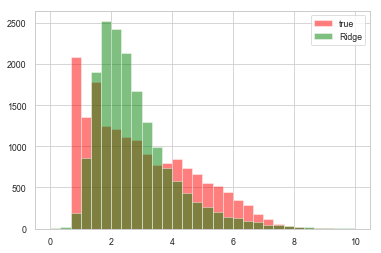

In [22]:
# train ridge
ridge, ridge_pred, ridge_experiment, ridge_test_pred = train_ridge(
        X_train_part,
        y_train_part,
        X_valid,
        y_valid,
        X_test_new)
ridge_pred1 = pred_to_src(ridge.predict(X_train_part))

print('Ridge valid mae: {}'.format(ridge_experiment['valid_mae']))

plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='Ridge', range=(0,10));
plt.legend();

Ridge valid mae: 1.0779352274080007


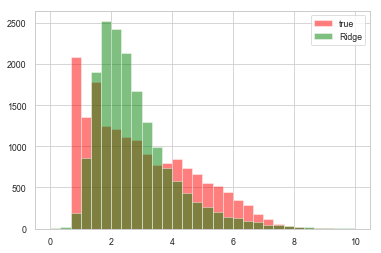

In [23]:
print('Ridge valid mae: {}'.format(ridge_experiment['valid_mae']))

plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='Ridge', range=(0,10));
plt.legend();

In [24]:
lgm, lgb_pred, lgm_experiment, lgm_test_pred = train_lgm(
        X_train_part,
        y_train_part,
        X_valid,
        y_valid,
        X_test_new)
lgb_pred1 = pred_to_src(lgm.predict(X_train_part))
print('LGM valid mae: {}'.format(lgm_experiment['valid_mae']))

(39987, 60272)
[1]	valid_0's l1: 0.381775
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l1: 0.375704
[3]	valid_0's l1: 0.370601
[4]	valid_0's l1: 0.366424
[5]	valid_0's l1: 0.362416
[6]	valid_0's l1: 0.358914
[7]	valid_0's l1: 0.355953
[8]	valid_0's l1: 0.353342
[9]	valid_0's l1: 0.351193
[10]	valid_0's l1: 0.349128
[11]	valid_0's l1: 0.34728
[12]	valid_0's l1: 0.345294
[13]	valid_0's l1: 0.343706
[14]	valid_0's l1: 0.342464
[15]	valid_0's l1: 0.341168
[16]	valid_0's l1: 0.340208
[17]	valid_0's l1: 0.338749
[18]	valid_0's l1: 0.337708
[19]	valid_0's l1: 0.336779
[20]	valid_0's l1: 0.336102
[21]	valid_0's l1: 0.335453
[22]	valid_0's l1: 0.334835
[23]	valid_0's l1: 0.333873
[24]	valid_0's l1: 0.333243
[25]	valid_0's l1: 0.332697
[26]	valid_0's l1: 0.332067
[27]	valid_0's l1: 0.331456
[28]	valid_0's l1: 0.330816
[29]	valid_0's l1: 0.330333
[30]	valid_0's l1: 0.329918
[31]	valid_0's l1: 0.329271
[32]	valid_0's l1: 0.328735
[33]	valid_0's l1: 0.328403
[34]	vali

[286]	valid_0's l1: 0.310677
[287]	valid_0's l1: 0.310655
[288]	valid_0's l1: 0.310628
[289]	valid_0's l1: 0.310637
[290]	valid_0's l1: 0.31066
[291]	valid_0's l1: 0.310662
[292]	valid_0's l1: 0.310657
[293]	valid_0's l1: 0.310648
[294]	valid_0's l1: 0.31063
[295]	valid_0's l1: 0.310635
[296]	valid_0's l1: 0.31062
[297]	valid_0's l1: 0.3106
[298]	valid_0's l1: 0.310616
[299]	valid_0's l1: 0.310637
[300]	valid_0's l1: 0.310663
[301]	valid_0's l1: 0.310652
[302]	valid_0's l1: 0.310616
[303]	valid_0's l1: 0.310618
[304]	valid_0's l1: 0.3106
[305]	valid_0's l1: 0.310611
[306]	valid_0's l1: 0.310576
[307]	valid_0's l1: 0.310533
[308]	valid_0's l1: 0.31051
[309]	valid_0's l1: 0.310499
[310]	valid_0's l1: 0.310474
[311]	valid_0's l1: 0.310449
[312]	valid_0's l1: 0.310454
[313]	valid_0's l1: 0.310451
[314]	valid_0's l1: 0.310457
[315]	valid_0's l1: 0.310431
[316]	valid_0's l1: 0.310428
[317]	valid_0's l1: 0.310416
[318]	valid_0's l1: 0.310369
[319]	valid_0's l1: 0.310377
[320]	valid_0's l1: 0.

LGM valid mae: 1.1427492959135814


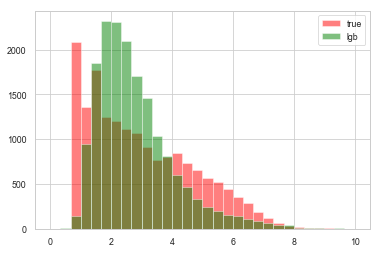

In [25]:
print('LGM valid mae: {}'.format(lgm_experiment['valid_mae']))
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(lgb_pred, bins=30, alpha=.5, color='green', label='lgb', range=(0,10));
plt.legend();

In [26]:
sgd, sgd_pred, sgd_experiment, sgd_test_pred = train_sgd(
        X_train_part,
        y_train_part,
        X_valid,
        y_valid,
        X_test_new)
sgd_pred11 = pred_to_src(sgd.predict(X_train_part))

print('SGD valid mae: {}'.format(sgd_experiment['valid_mae']))

(39987, 60272)
-- Epoch 1
Norm: 1.90, NNZs: 57944, Bias: 0.022690, T: 39987, Avg. loss: 0.323917
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 2.19, NNZs: 58020, Bias: 0.025831, T: 79974, Avg. loss: 0.296857
Total training time: 0.16 seconds.
-- Epoch 3
Norm: 2.44, NNZs: 58043, Bias: 0.028438, T: 119961, Avg. loss: 0.288476
Total training time: 0.25 seconds.
-- Epoch 4
Norm: 2.70, NNZs: 58055, Bias: 0.031012, T: 159948, Avg. loss: 0.281711
Total training time: 0.33 seconds.
-- Epoch 5
Norm: 2.92, NNZs: 58065, Bias: 0.032809, T: 199935, Avg. loss: 0.276148
Total training time: 0.42 seconds.
-- Epoch 6
Norm: 3.14, NNZs: 58080, Bias: 0.034643, T: 239922, Avg. loss: 0.271226
Total training time: 0.50 seconds.
-- Epoch 7
Norm: 3.35, NNZs: 58085, Bias: 0.036404, T: 279909, Avg. loss: 0.267023
Total training time: 0.58 seconds.
-- Epoch 8
Norm: 3.55, NNZs: 58092, Bias: 0.038295, T: 319896, Avg. loss: 0.263231
Total training time: 0.67 seconds.
-- Epoch 9
Norm: 3.74, NNZs: 58099, Bias: 0

Norm: 9.50, NNZs: 58156, Bias: 0.099721, T: 2879064, Avg. loss: 0.192388
Total training time: 6.22 seconds.
-- Epoch 73
Norm: 9.56, NNZs: 58156, Bias: 0.100337, T: 2919051, Avg. loss: 0.191940
Total training time: 6.30 seconds.
-- Epoch 74
Norm: 9.61, NNZs: 58156, Bias: 0.101052, T: 2959038, Avg. loss: 0.191466
Total training time: 6.39 seconds.
-- Epoch 75
Norm: 9.67, NNZs: 58156, Bias: 0.101608, T: 2999025, Avg. loss: 0.190998
Total training time: 6.48 seconds.
-- Epoch 76
Norm: 9.72, NNZs: 58157, Bias: 0.102189, T: 3039012, Avg. loss: 0.190541
Total training time: 6.56 seconds.
-- Epoch 77
Norm: 9.77, NNZs: 58157, Bias: 0.102854, T: 3078999, Avg. loss: 0.190113
Total training time: 6.64 seconds.
-- Epoch 78
Norm: 9.83, NNZs: 58157, Bias: 0.103485, T: 3118986, Avg. loss: 0.189654
Total training time: 6.72 seconds.
-- Epoch 79
Norm: 9.88, NNZs: 58157, Bias: 0.104077, T: 3158973, Avg. loss: 0.189232
Total training time: 6.80 seconds.
-- Epoch 80
Norm: 9.93, NNZs: 58157, Bias: 0.104704,

Norm: 12.51, NNZs: 58159, Bias: 0.135003, T: 5598180, Avg. loss: 0.169427
Total training time: 12.07 seconds.
-- Epoch 141
Norm: 12.55, NNZs: 58159, Bias: 0.135391, T: 5638167, Avg. loss: 0.169178
Total training time: 12.15 seconds.
-- Epoch 142
Norm: 12.58, NNZs: 58159, Bias: 0.135844, T: 5678154, Avg. loss: 0.168943
Total training time: 12.23 seconds.
-- Epoch 143
Norm: 12.62, NNZs: 58159, Bias: 0.136296, T: 5718141, Avg. loss: 0.168701
Total training time: 12.31 seconds.
-- Epoch 144
Norm: 12.65, NNZs: 58159, Bias: 0.136632, T: 5758128, Avg. loss: 0.168445
Total training time: 12.39 seconds.
-- Epoch 145
Norm: 12.69, NNZs: 58160, Bias: 0.137107, T: 5798115, Avg. loss: 0.168203
Total training time: 12.47 seconds.
-- Epoch 146
Norm: 12.72, NNZs: 58161, Bias: 0.137522, T: 5838102, Avg. loss: 0.167977
Total training time: 12.56 seconds.
-- Epoch 147
Norm: 12.76, NNZs: 58161, Bias: 0.137880, T: 5878089, Avg. loss: 0.167734
Total training time: 12.63 seconds.
-- Epoch 148
Norm: 12.79, NNZ

Norm: 14.65, NNZs: 58163, Bias: 0.159711, T: 8357283, Avg. loss: 0.155681
Total training time: 17.78 seconds.
-- Epoch 210
Norm: 14.68, NNZs: 58163, Bias: 0.160035, T: 8397270, Avg. loss: 0.155518
Total training time: 17.86 seconds.
-- Epoch 211
Norm: 14.70, NNZs: 58163, Bias: 0.160287, T: 8437257, Avg. loss: 0.155348
Total training time: 17.94 seconds.
-- Epoch 212
Norm: 14.73, NNZs: 58163, Bias: 0.160658, T: 8477244, Avg. loss: 0.155177
Total training time: 18.01 seconds.
-- Epoch 213
Norm: 14.76, NNZs: 58163, Bias: 0.160895, T: 8517231, Avg. loss: 0.155031
Total training time: 18.09 seconds.
-- Epoch 214
Norm: 14.78, NNZs: 58163, Bias: 0.161199, T: 8557218, Avg. loss: 0.154869
Total training time: 18.16 seconds.
-- Epoch 215
Norm: 14.81, NNZs: 58163, Bias: 0.161524, T: 8597205, Avg. loss: 0.154707
Total training time: 18.24 seconds.
-- Epoch 216
Norm: 14.84, NNZs: 58163, Bias: 0.161766, T: 8637192, Avg. loss: 0.154553
Total training time: 18.32 seconds.
-- Epoch 217
Norm: 14.86, NNZ

Norm: 16.30, NNZs: 58165, Bias: 0.177634, T: 11036412, Avg. loss: 0.146248
Total training time: 23.27 seconds.
-- Epoch 277
Norm: 16.33, NNZs: 58165, Bias: 0.177894, T: 11076399, Avg. loss: 0.146111
Total training time: 23.34 seconds.
-- Epoch 278
Norm: 16.35, NNZs: 58165, Bias: 0.178160, T: 11116386, Avg. loss: 0.145999
Total training time: 23.42 seconds.
-- Epoch 279
Norm: 16.37, NNZs: 58165, Bias: 0.178402, T: 11156373, Avg. loss: 0.145881
Total training time: 23.49 seconds.
-- Epoch 280
Norm: 16.39, NNZs: 58165, Bias: 0.178656, T: 11196360, Avg. loss: 0.145762
Total training time: 23.57 seconds.
-- Epoch 281
Norm: 16.42, NNZs: 58165, Bias: 0.178872, T: 11236347, Avg. loss: 0.145626
Total training time: 23.65 seconds.
-- Epoch 282
Norm: 16.44, NNZs: 58165, Bias: 0.179140, T: 11276334, Avg. loss: 0.145514
Total training time: 23.73 seconds.
-- Epoch 283
Norm: 16.46, NNZs: 58165, Bias: 0.179333, T: 11316321, Avg. loss: 0.145405
Total training time: 23.81 seconds.
-- Epoch 284
Norm: 16

Norm: 17.74, NNZs: 58168, Bias: 0.192431, T: 13795515, Avg. loss: 0.138704
Total training time: 28.84 seconds.
-- Epoch 346
Norm: 17.76, NNZs: 58168, Bias: 0.192620, T: 13835502, Avg. loss: 0.138608
Total training time: 28.91 seconds.
-- Epoch 347
Norm: 17.78, NNZs: 58168, Bias: 0.192784, T: 13875489, Avg. loss: 0.138513
Total training time: 28.99 seconds.
-- Epoch 348
Norm: 17.80, NNZs: 58168, Bias: 0.192957, T: 13915476, Avg. loss: 0.138412
Total training time: 29.07 seconds.
-- Epoch 349
Norm: 17.82, NNZs: 58168, Bias: 0.193185, T: 13955463, Avg. loss: 0.138324
Total training time: 29.14 seconds.
-- Epoch 350
Norm: 17.84, NNZs: 58168, Bias: 0.193268, T: 13995450, Avg. loss: 0.138218
Total training time: 29.22 seconds.
-- Epoch 351
Norm: 17.86, NNZs: 58168, Bias: 0.193544, T: 14035437, Avg. loss: 0.138120
Total training time: 29.31 seconds.
-- Epoch 352
Norm: 17.87, NNZs: 58168, Bias: 0.193673, T: 14075424, Avg. loss: 0.138024
Total training time: 29.38 seconds.
-- Epoch 353
Norm: 17

Norm: 18.96, NNZs: 58168, Bias: 0.203745, T: 16474644, Avg. loss: 0.132745
Total training time: 34.45 seconds.
-- Epoch 413
Norm: 18.97, NNZs: 58168, Bias: 0.203866, T: 16514631, Avg. loss: 0.132664
Total training time: 34.53 seconds.
-- Epoch 414
Norm: 18.99, NNZs: 58168, Bias: 0.204024, T: 16554618, Avg. loss: 0.132585
Total training time: 34.60 seconds.
-- Epoch 415
Norm: 19.01, NNZs: 58168, Bias: 0.204137, T: 16594605, Avg. loss: 0.132501
Total training time: 34.68 seconds.
-- Epoch 416
Norm: 19.03, NNZs: 58168, Bias: 0.204338, T: 16634592, Avg. loss: 0.132426
Total training time: 34.76 seconds.
-- Epoch 417
Norm: 19.04, NNZs: 58168, Bias: 0.204469, T: 16674579, Avg. loss: 0.132347
Total training time: 34.83 seconds.
-- Epoch 418
Norm: 19.06, NNZs: 58168, Bias: 0.204649, T: 16714566, Avg. loss: 0.132267
Total training time: 34.92 seconds.
-- Epoch 419
Norm: 19.08, NNZs: 58168, Bias: 0.204790, T: 16754553, Avg. loss: 0.132186
Total training time: 34.99 seconds.
-- Epoch 420
Norm: 19

Norm: 20.04, NNZs: 58170, Bias: 0.213282, T: 19153773, Avg. loss: 0.127774
Total training time: 40.25 seconds.
-- Epoch 480
Norm: 20.05, NNZs: 58170, Bias: 0.213394, T: 19193760, Avg. loss: 0.127705
Total training time: 40.32 seconds.
-- Epoch 481
Norm: 20.07, NNZs: 58170, Bias: 0.213500, T: 19233747, Avg. loss: 0.127634
Total training time: 40.40 seconds.
-- Epoch 482
Norm: 20.08, NNZs: 58170, Bias: 0.213669, T: 19273734, Avg. loss: 0.127568
Total training time: 40.48 seconds.
-- Epoch 483
Norm: 20.10, NNZs: 58170, Bias: 0.213868, T: 19313721, Avg. loss: 0.127491
Total training time: 40.56 seconds.
-- Epoch 484
Norm: 20.12, NNZs: 58170, Bias: 0.213880, T: 19353708, Avg. loss: 0.127435
Total training time: 40.69 seconds.
-- Epoch 485
Norm: 20.13, NNZs: 58170, Bias: 0.214040, T: 19393695, Avg. loss: 0.127364
Total training time: 40.78 seconds.
-- Epoch 486
Norm: 20.15, NNZs: 58170, Bias: 0.214195, T: 19433682, Avg. loss: 0.127300
Total training time: 40.86 seconds.
-- Epoch 487
Norm: 20

Norm: 21.04, NNZs: 58171, Bias: 0.221408, T: 21912876, Avg. loss: 0.123392
Total training time: 46.10 seconds.
-- Epoch 549
Norm: 21.06, NNZs: 58171, Bias: 0.221534, T: 21952863, Avg. loss: 0.123333
Total training time: 46.17 seconds.
-- Epoch 550
Norm: 21.07, NNZs: 58171, Bias: 0.221645, T: 21992850, Avg. loss: 0.123275
Total training time: 46.25 seconds.
-- Epoch 551
Norm: 21.09, NNZs: 58171, Bias: 0.221762, T: 22032837, Avg. loss: 0.123216
Total training time: 46.33 seconds.
-- Epoch 552
Norm: 21.10, NNZs: 58171, Bias: 0.221862, T: 22072824, Avg. loss: 0.123155
Total training time: 46.41 seconds.
-- Epoch 553
Norm: 21.11, NNZs: 58171, Bias: 0.221961, T: 22112811, Avg. loss: 0.123104
Total training time: 46.48 seconds.
-- Epoch 554
Norm: 21.13, NNZs: 58171, Bias: 0.222066, T: 22152798, Avg. loss: 0.123041
Total training time: 46.55 seconds.
-- Epoch 555
Norm: 21.14, NNZs: 58171, Bias: 0.222177, T: 22192785, Avg. loss: 0.122982
Total training time: 46.62 seconds.
-- Epoch 556
Norm: 21

Norm: 21.96, NNZs: 58172, Bias: 0.228777, T: 24671979, Avg. loss: 0.119581
Total training time: 51.67 seconds.
-- Epoch 618
Norm: 21.98, NNZs: 58172, Bias: 0.228879, T: 24711966, Avg. loss: 0.119529
Total training time: 51.76 seconds.
-- Epoch 619
Norm: 21.99, NNZs: 58172, Bias: 0.229020, T: 24751953, Avg. loss: 0.119477
Total training time: 51.84 seconds.
-- Epoch 620
Norm: 22.00, NNZs: 58172, Bias: 0.229077, T: 24791940, Avg. loss: 0.119428
Total training time: 51.92 seconds.
-- Epoch 621
Norm: 22.02, NNZs: 58172, Bias: 0.229206, T: 24831927, Avg. loss: 0.119372
Total training time: 52.00 seconds.
-- Epoch 622
Norm: 22.03, NNZs: 58172, Bias: 0.229291, T: 24871914, Avg. loss: 0.119322
Total training time: 52.09 seconds.
-- Epoch 623
Norm: 22.04, NNZs: 58172, Bias: 0.229433, T: 24911901, Avg. loss: 0.119272
Total training time: 52.17 seconds.
-- Epoch 624
Norm: 22.05, NNZs: 58172, Bias: 0.229508, T: 24951888, Avg. loss: 0.119219
Total training time: 52.25 seconds.
-- Epoch 625
Norm: 22

Norm: 22.79, NNZs: 58172, Bias: 0.235389, T: 27351108, Avg. loss: 0.116303
Total training time: 57.15 seconds.
-- Epoch 685
Norm: 22.80, NNZs: 58172, Bias: 0.235466, T: 27391095, Avg. loss: 0.116260
Total training time: 57.23 seconds.
-- Epoch 686
Norm: 22.81, NNZs: 58172, Bias: 0.235577, T: 27431082, Avg. loss: 0.116213
Total training time: 57.31 seconds.
-- Epoch 687
Norm: 22.83, NNZs: 58172, Bias: 0.235640, T: 27471069, Avg. loss: 0.116164
Total training time: 57.40 seconds.
-- Epoch 688
Norm: 22.84, NNZs: 58172, Bias: 0.235767, T: 27511056, Avg. loss: 0.116118
Total training time: 57.48 seconds.
-- Epoch 689
Norm: 22.85, NNZs: 58172, Bias: 0.235843, T: 27551043, Avg. loss: 0.116074
Total training time: 57.56 seconds.
-- Epoch 690
Norm: 22.86, NNZs: 58172, Bias: 0.235994, T: 27591030, Avg. loss: 0.116024
Total training time: 57.64 seconds.
-- Epoch 691
Norm: 22.87, NNZs: 58172, Bias: 0.236042, T: 27631017, Avg. loss: 0.115983
Total training time: 57.72 seconds.
-- Epoch 692
Norm: 22

Norm: 23.57, NNZs: 58172, Bias: 0.241491, T: 30070224, Avg. loss: 0.113344
Total training time: 62.98 seconds.
-- Epoch 753
Norm: 23.58, NNZs: 58172, Bias: 0.241544, T: 30110211, Avg. loss: 0.113296
Total training time: 63.05 seconds.
-- Epoch 754
Norm: 23.59, NNZs: 58172, Bias: 0.241672, T: 30150198, Avg. loss: 0.113261
Total training time: 63.13 seconds.
-- Epoch 755
Norm: 23.60, NNZs: 58172, Bias: 0.241753, T: 30190185, Avg. loss: 0.113216
Total training time: 63.21 seconds.
-- Epoch 756
Norm: 23.61, NNZs: 58172, Bias: 0.241822, T: 30230172, Avg. loss: 0.113179
Total training time: 63.28 seconds.
-- Epoch 757
Norm: 23.62, NNZs: 58172, Bias: 0.241930, T: 30270159, Avg. loss: 0.113137
Total training time: 63.36 seconds.
-- Epoch 758
Norm: 23.63, NNZs: 58172, Bias: 0.241993, T: 30310146, Avg. loss: 0.113098
Total training time: 63.43 seconds.
-- Epoch 759
Norm: 23.64, NNZs: 58172, Bias: 0.242089, T: 30350133, Avg. loss: 0.113056
Total training time: 63.51 seconds.
-- Epoch 760
Norm: 23

Norm: 24.30, NNZs: 58172, Bias: 0.247021, T: 32829327, Avg. loss: 0.110654
Total training time: 68.42 seconds.
-- Epoch 822
Norm: 24.31, NNZs: 58172, Bias: 0.247074, T: 32869314, Avg. loss: 0.110621
Total training time: 68.49 seconds.
-- Epoch 823
Norm: 24.32, NNZs: 58172, Bias: 0.247166, T: 32909301, Avg. loss: 0.110577
Total training time: 68.56 seconds.
-- Epoch 824
Norm: 24.33, NNZs: 58172, Bias: 0.247238, T: 32949288, Avg. loss: 0.110542
Total training time: 68.63 seconds.
-- Epoch 825
Norm: 24.34, NNZs: 58172, Bias: 0.247347, T: 32989275, Avg. loss: 0.110505
Total training time: 68.71 seconds.
-- Epoch 826
Norm: 24.35, NNZs: 58172, Bias: 0.247400, T: 33029262, Avg. loss: 0.110470
Total training time: 68.78 seconds.
-- Epoch 827
Norm: 24.36, NNZs: 58172, Bias: 0.247477, T: 33069249, Avg. loss: 0.110434
Total training time: 68.87 seconds.
-- Epoch 828
Norm: 24.37, NNZs: 58172, Bias: 0.247542, T: 33109236, Avg. loss: 0.110399
Total training time: 68.94 seconds.
-- Epoch 829
Norm: 24

Norm: 24.96, NNZs: 58173, Bias: 0.251905, T: 35508456, Avg. loss: 0.108286
Total training time: 73.53 seconds.
-- Epoch 889
Norm: 24.97, NNZs: 58173, Bias: 0.251949, T: 35548443, Avg. loss: 0.108254
Total training time: 73.61 seconds.
-- Epoch 890
Norm: 24.98, NNZs: 58173, Bias: 0.252038, T: 35588430, Avg. loss: 0.108221
Total training time: 73.70 seconds.
-- Epoch 891
Norm: 24.99, NNZs: 58173, Bias: 0.252087, T: 35628417, Avg. loss: 0.108186
Total training time: 73.78 seconds.
-- Epoch 892
Norm: 25.00, NNZs: 58173, Bias: 0.252195, T: 35668404, Avg. loss: 0.108154
Total training time: 73.85 seconds.
-- Epoch 893
Norm: 25.01, NNZs: 58173, Bias: 0.252245, T: 35708391, Avg. loss: 0.108121
Total training time: 73.92 seconds.
-- Epoch 894
Norm: 25.02, NNZs: 58173, Bias: 0.252307, T: 35748378, Avg. loss: 0.108085
Total training time: 74.00 seconds.
-- Epoch 895
Norm: 25.03, NNZs: 58173, Bias: 0.252384, T: 35788365, Avg. loss: 0.108054
Total training time: 74.08 seconds.
-- Epoch 896
Norm: 25

Norm: 25.58, NNZs: 58175, Bias: 0.256354, T: 38187585, Avg. loss: 0.106126
Total training time: 78.69 seconds.
-- Epoch 956
Norm: 25.59, NNZs: 58175, Bias: 0.256402, T: 38227572, Avg. loss: 0.106093
Total training time: 78.76 seconds.
-- Epoch 957
Norm: 25.60, NNZs: 58175, Bias: 0.256499, T: 38267559, Avg. loss: 0.106060
Total training time: 78.83 seconds.
-- Epoch 958
Norm: 25.61, NNZs: 58175, Bias: 0.256509, T: 38307546, Avg. loss: 0.106033
Total training time: 78.90 seconds.
-- Epoch 959
Norm: 25.62, NNZs: 58175, Bias: 0.256578, T: 38347533, Avg. loss: 0.106001
Total training time: 78.97 seconds.
-- Epoch 960
Norm: 25.63, NNZs: 58175, Bias: 0.256650, T: 38387520, Avg. loss: 0.105969
Total training time: 79.04 seconds.
-- Epoch 961
Norm: 25.64, NNZs: 58175, Bias: 0.256702, T: 38427507, Avg. loss: 0.105940
Total training time: 79.11 seconds.
-- Epoch 962
Norm: 25.65, NNZs: 58175, Bias: 0.256792, T: 38467494, Avg. loss: 0.105908
Total training time: 79.18 seconds.
-- Epoch 963
Norm: 25

SGD valid mae: 1.0833540387824263


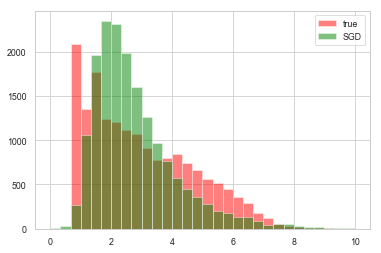

In [27]:
print('SGD valid mae: {}'.format(sgd_experiment['valid_mae']))
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(sgd_pred, bins=30, alpha=.5, color='green', label='SGD', range=(0,10));
plt.legend();

In [29]:
print('SGD valid mae: {}'.format(sgd_experiment['valid_mae']))

SGD valid mae: 1.0833540387824263


LGM valid mae: 1.1427492959135814
Ridge valid mae: 1.0779352274080007
Mix valid mae: 1.081475528598624


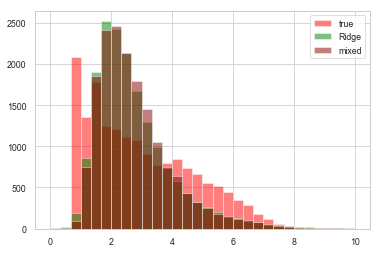

In [30]:
coef_1 = 0.6
coef_2 = 0.4

mix_pred = coef_1 * lgb_pred + coef_2 * ridge_pred
#mix_pred = coef_1 * sgd_pred + coef_2 * ridge_pred
#mix_pred = coef_1 * lgb_pred + coef_2 * ridge_pred
#mix_pred = np.expm1(coef_1 * 1/(lgb_pred**(-2)) + coef_2 * 1/(ridge_pred**(-2)))

print('LGM valid mae: {}'.format(lgm_experiment['valid_mae']))
print('Ridge valid mae: {}'.format(ridge_experiment['valid_mae']))
#print('SGD valid mae: {}'.format(sgd_experiment['valid_mae']))
print('Mix valid mae: {}'.format(mean_absolute_error(y_valid, mix_pred)))

plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
#plt.hist(np.log2(1+y_valid), bins=30, alpha=.5, color='gray', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='Ridge', range=(0,10));
plt.hist(mix_pred, bins=30, alpha=.5, color='maroon', label='mixed', range=(0,10));
plt.legend();

SGD valid mae: 1.0833540387824263
Ridge valid mae: 1.0779352274080007
Mix valid mae: 1.0762855110235636


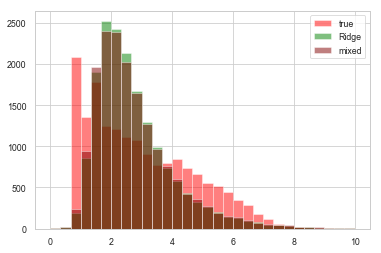

In [32]:
mix_pred = coef_1 * sgd_pred + coef_2 * ridge_pred

print('SGD valid mae: {}'.format(sgd_experiment['valid_mae']))
print('Ridge valid mae: {}'.format(ridge_experiment['valid_mae']))
print('Mix valid mae: {}'.format(mean_absolute_error(y_valid, mix_pred)))

plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='Ridge', range=(0,10));
plt.hist(mix_pred, bins=30, alpha=.5, color='maroon', label='mixed', range=(0,10));
plt.legend();

In [36]:
experiments[lgm_experiment['time']] = lgm_experiment
experiments[ridge_experiment['time']] = ridge_experiment
experiments[sgd_experiment['time']] = sgd_experiment

with open('medium_experiments.pickle', 'wb') as f:
    pickle.dump(experiments, f)

In [38]:
ridge, ridge_full_pred = full_fit(ridge, X_train_new, y_train_new, X_test_new)
#lgm, lgm_full_pred = full_lgm_fit(lgm, X_train_new, y_train_new, X_test_new)
sgb, sgb_full_pred = full_fit(sgd, X_train_new, y_train_new, X_test_new)

mix_full_pred = coef_1 * sgb_full_pred + coef_2 * ridge_full_pred

# ==> predict
full_pred_corrected = \
    mix_full_pred + (all_zero_mae - mix_full_pred.mean())
write_submission_file(prediction=full_pred_corrected,
                      filename=experiment['submission_file'])
# <== predict


-- Epoch 1
Norm: 1.99, NNZs: 60089, Bias: 0.024383, T: 57125, Avg. loss: 0.311981
Total training time: 0.10 seconds.
-- Epoch 2
Norm: 2.32, NNZs: 60165, Bias: 0.028250, T: 114250, Avg. loss: 0.288899
Total training time: 0.20 seconds.
-- Epoch 3
Norm: 2.64, NNZs: 60177, Bias: 0.031486, T: 171375, Avg. loss: 0.280308
Total training time: 0.30 seconds.
-- Epoch 4
Norm: 2.93, NNZs: 60188, Bias: 0.034375, T: 228500, Avg. loss: 0.273606
Total training time: 0.41 seconds.
-- Epoch 5
Norm: 3.20, NNZs: 60198, Bias: 0.036962, T: 285625, Avg. loss: 0.268053
Total training time: 0.51 seconds.
-- Epoch 6
Norm: 3.47, NNZs: 60206, Bias: 0.039889, T: 342750, Avg. loss: 0.263380
Total training time: 0.61 seconds.
-- Epoch 7
Norm: 3.71, NNZs: 60217, Bias: 0.042220, T: 399875, Avg. loss: 0.259259
Total training time: 0.72 seconds.
-- Epoch 8
Norm: 3.94, NNZs: 60223, Bias: 0.044701, T: 457000, Avg. loss: 0.255634
Total training time: 0.82 seconds.
-- Epoch 9
Norm: 4.16, NNZs: 60227, Bias: 0.046990, T: 51

Norm: 10.41, NNZs: 60254, Bias: 0.121986, T: 4055875, Avg. loss: 0.190337
Total training time: 9.36 seconds.
-- Epoch 72
Norm: 10.47, NNZs: 60254, Bias: 0.122742, T: 4113000, Avg. loss: 0.189910
Total training time: 9.47 seconds.
-- Epoch 73
Norm: 10.53, NNZs: 60254, Bias: 0.123540, T: 4170125, Avg. loss: 0.189502
Total training time: 9.59 seconds.
-- Epoch 74
Norm: 10.59, NNZs: 60254, Bias: 0.124298, T: 4227250, Avg. loss: 0.189079
Total training time: 9.71 seconds.
-- Epoch 75
Norm: 10.65, NNZs: 60254, Bias: 0.125026, T: 4284375, Avg. loss: 0.188659
Total training time: 9.86 seconds.
-- Epoch 76
Norm: 10.70, NNZs: 60254, Bias: 0.125801, T: 4341500, Avg. loss: 0.188270
Total training time: 10.00 seconds.
-- Epoch 77
Norm: 10.76, NNZs: 60254, Bias: 0.126411, T: 4398625, Avg. loss: 0.187858
Total training time: 10.13 seconds.
-- Epoch 78
Norm: 10.81, NNZs: 60254, Bias: 0.127187, T: 4455750, Avg. loss: 0.187493
Total training time: 10.24 seconds.
-- Epoch 79
Norm: 10.87, NNZs: 60254, Bia

Norm: 13.56, NNZs: 60254, Bias: 0.162598, T: 7883250, Avg. loss: 0.170135
Total training time: 18.12 seconds.
-- Epoch 139
Norm: 13.60, NNZs: 60254, Bias: 0.162984, T: 7940375, Avg. loss: 0.169911
Total training time: 18.25 seconds.
-- Epoch 140
Norm: 13.64, NNZs: 60254, Bias: 0.163530, T: 7997500, Avg. loss: 0.169692
Total training time: 18.39 seconds.
-- Epoch 141
Norm: 13.68, NNZs: 60254, Bias: 0.163906, T: 8054625, Avg. loss: 0.169457
Total training time: 18.52 seconds.
-- Epoch 142
Norm: 13.72, NNZs: 60254, Bias: 0.164474, T: 8111750, Avg. loss: 0.169266
Total training time: 18.64 seconds.
-- Epoch 143
Norm: 13.75, NNZs: 60254, Bias: 0.164972, T: 8168875, Avg. loss: 0.169042
Total training time: 18.76 seconds.
-- Epoch 144
Norm: 13.79, NNZs: 60254, Bias: 0.165450, T: 8226000, Avg. loss: 0.168828
Total training time: 18.89 seconds.
-- Epoch 145
Norm: 13.83, NNZs: 60254, Bias: 0.165947, T: 8283125, Avg. loss: 0.168607
Total training time: 19.00 seconds.
-- Epoch 146
Norm: 13.87, NNZ

Norm: 15.82, NNZs: 60256, Bias: 0.190308, T: 11710625, Avg. loss: 0.158013
Total training time: 27.31 seconds.
-- Epoch 206
Norm: 15.85, NNZs: 60256, Bias: 0.190699, T: 11767750, Avg. loss: 0.157873
Total training time: 27.44 seconds.
-- Epoch 207
Norm: 15.88, NNZs: 60256, Bias: 0.191041, T: 11824875, Avg. loss: 0.157714
Total training time: 27.58 seconds.
-- Epoch 208
Norm: 15.91, NNZs: 60256, Bias: 0.191424, T: 11882000, Avg. loss: 0.157572
Total training time: 27.74 seconds.
-- Epoch 209
Norm: 15.94, NNZs: 60256, Bias: 0.191734, T: 11939125, Avg. loss: 0.157428
Total training time: 27.86 seconds.
-- Epoch 210
Norm: 15.97, NNZs: 60256, Bias: 0.192099, T: 11996250, Avg. loss: 0.157284
Total training time: 28.00 seconds.
-- Epoch 211
Norm: 16.00, NNZs: 60256, Bias: 0.192480, T: 12053375, Avg. loss: 0.157140
Total training time: 28.12 seconds.
-- Epoch 212
Norm: 16.03, NNZs: 60256, Bias: 0.192794, T: 12110500, Avg. loss: 0.156998
Total training time: 28.25 seconds.
-- Epoch 213
Norm: 16

Norm: 17.65, NNZs: 60258, Bias: 0.212007, T: 15595125, Avg. loss: 0.149308
Total training time: 36.87 seconds.
-- Epoch 274
Norm: 17.68, NNZs: 60259, Bias: 0.212319, T: 15652250, Avg. loss: 0.149193
Total training time: 37.00 seconds.
-- Epoch 275
Norm: 17.70, NNZs: 60259, Bias: 0.212654, T: 15709375, Avg. loss: 0.149085
Total training time: 37.13 seconds.
-- Epoch 276
Norm: 17.73, NNZs: 60259, Bias: 0.212880, T: 15766500, Avg. loss: 0.148977
Total training time: 37.24 seconds.
-- Epoch 277
Norm: 17.75, NNZs: 60259, Bias: 0.213180, T: 15823625, Avg. loss: 0.148871
Total training time: 37.43 seconds.
-- Epoch 278
Norm: 17.77, NNZs: 60259, Bias: 0.213424, T: 15880750, Avg. loss: 0.148763
Total training time: 37.61 seconds.
-- Epoch 279
Norm: 17.80, NNZs: 60259, Bias: 0.213706, T: 15937875, Avg. loss: 0.148646
Total training time: 37.73 seconds.
-- Epoch 280
Norm: 17.82, NNZs: 60259, Bias: 0.214022, T: 15995000, Avg. loss: 0.148546
Total training time: 37.85 seconds.
-- Epoch 281
Norm: 17

Norm: 19.17, NNZs: 60260, Bias: 0.228867, T: 19422500, Avg. loss: 0.142696
Total training time: 45.90 seconds.
-- Epoch 341
Norm: 19.19, NNZs: 60260, Bias: 0.229093, T: 19479625, Avg. loss: 0.142608
Total training time: 46.01 seconds.
-- Epoch 342
Norm: 19.21, NNZs: 60261, Bias: 0.229358, T: 19536750, Avg. loss: 0.142522
Total training time: 46.15 seconds.
-- Epoch 343
Norm: 19.23, NNZs: 60261, Bias: 0.229549, T: 19593875, Avg. loss: 0.142443
Total training time: 46.28 seconds.
-- Epoch 344
Norm: 19.26, NNZs: 60261, Bias: 0.229830, T: 19651000, Avg. loss: 0.142347
Total training time: 46.41 seconds.
-- Epoch 345
Norm: 19.28, NNZs: 60261, Bias: 0.230013, T: 19708125, Avg. loss: 0.142265
Total training time: 46.53 seconds.
-- Epoch 346
Norm: 19.30, NNZs: 60261, Bias: 0.230151, T: 19765250, Avg. loss: 0.142171
Total training time: 46.66 seconds.
-- Epoch 347
Norm: 19.32, NNZs: 60261, Bias: 0.230431, T: 19822375, Avg. loss: 0.142095
Total training time: 46.78 seconds.
-- Epoch 348
Norm: 19

Norm: 20.50, NNZs: 60261, Bias: 0.242737, T: 23249875, Avg. loss: 0.137336
Total training time: 54.86 seconds.
-- Epoch 408
Norm: 20.52, NNZs: 60261, Bias: 0.242917, T: 23307000, Avg. loss: 0.137275
Total training time: 54.98 seconds.
-- Epoch 409
Norm: 20.53, NNZs: 60261, Bias: 0.243153, T: 23364125, Avg. loss: 0.137200
Total training time: 55.11 seconds.
-- Epoch 410
Norm: 20.55, NNZs: 60261, Bias: 0.243272, T: 23421250, Avg. loss: 0.137130
Total training time: 55.22 seconds.
-- Epoch 411
Norm: 20.57, NNZs: 60261, Bias: 0.243527, T: 23478375, Avg. loss: 0.137060
Total training time: 55.34 seconds.
-- Epoch 412
Norm: 20.59, NNZs: 60261, Bias: 0.243674, T: 23535500, Avg. loss: 0.136987
Total training time: 55.46 seconds.
-- Epoch 413
Norm: 20.61, NNZs: 60261, Bias: 0.243898, T: 23592625, Avg. loss: 0.136912
Total training time: 55.58 seconds.
-- Epoch 414
Norm: 20.63, NNZs: 60261, Bias: 0.244027, T: 23649750, Avg. loss: 0.136844
Total training time: 55.72 seconds.
-- Epoch 415
Norm: 20

Norm: 21.67, NNZs: 60261, Bias: 0.254409, T: 27077250, Avg. loss: 0.132897
Total training time: 63.19 seconds.
-- Epoch 475
Norm: 21.69, NNZs: 60261, Bias: 0.254559, T: 27134375, Avg. loss: 0.132840
Total training time: 63.29 seconds.
-- Epoch 476
Norm: 21.70, NNZs: 60261, Bias: 0.254745, T: 27191500, Avg. loss: 0.132774
Total training time: 63.41 seconds.
-- Epoch 477
Norm: 21.72, NNZs: 60261, Bias: 0.254884, T: 27248625, Avg. loss: 0.132719
Total training time: 63.53 seconds.
-- Epoch 478
Norm: 21.74, NNZs: 60261, Bias: 0.255037, T: 27305750, Avg. loss: 0.132657
Total training time: 63.66 seconds.
-- Epoch 479
Norm: 21.75, NNZs: 60261, Bias: 0.255185, T: 27362875, Avg. loss: 0.132598
Total training time: 63.85 seconds.
-- Epoch 480
Norm: 21.77, NNZs: 60261, Bias: 0.255373, T: 27420000, Avg. loss: 0.132536
Total training time: 64.05 seconds.
-- Epoch 481
Norm: 21.79, NNZs: 60261, Bias: 0.255518, T: 27477125, Avg. loss: 0.132478
Total training time: 64.26 seconds.
-- Epoch 482
Norm: 21

Norm: 22.73, NNZs: 60261, Bias: 0.264286, T: 30904625, Avg. loss: 0.129112
Total training time: 71.83 seconds.
-- Epoch 542
Norm: 22.74, NNZs: 60261, Bias: 0.264435, T: 30961750, Avg. loss: 0.129059
Total training time: 71.94 seconds.
-- Epoch 543
Norm: 22.76, NNZs: 60261, Bias: 0.264568, T: 31018875, Avg. loss: 0.129007
Total training time: 72.06 seconds.
-- Epoch 544
Norm: 22.77, NNZs: 60261, Bias: 0.264722, T: 31076000, Avg. loss: 0.128957
Total training time: 72.18 seconds.
-- Epoch 545
Norm: 22.79, NNZs: 60261, Bias: 0.264858, T: 31133125, Avg. loss: 0.128901
Total training time: 72.30 seconds.
-- Epoch 546
Norm: 22.80, NNZs: 60261, Bias: 0.264995, T: 31190250, Avg. loss: 0.128848
Total training time: 72.41 seconds.
-- Epoch 547
Norm: 22.82, NNZs: 60261, Bias: 0.265127, T: 31247375, Avg. loss: 0.128799
Total training time: 72.53 seconds.
-- Epoch 548
Norm: 22.83, NNZs: 60261, Bias: 0.265246, T: 31304500, Avg. loss: 0.128743
Total training time: 72.65 seconds.
-- Epoch 549
Norm: 22

Norm: 23.71, NNZs: 60261, Bias: 0.273188, T: 34789125, Avg. loss: 0.125776
Total training time: 80.39 seconds.
-- Epoch 610
Norm: 23.72, NNZs: 60261, Bias: 0.273335, T: 34846250, Avg. loss: 0.125728
Total training time: 80.60 seconds.
-- Epoch 611
Norm: 23.74, NNZs: 60261, Bias: 0.273425, T: 34903375, Avg. loss: 0.125685
Total training time: 80.82 seconds.
-- Epoch 612
Norm: 23.75, NNZs: 60261, Bias: 0.273513, T: 34960500, Avg. loss: 0.125632
Total training time: 81.01 seconds.
-- Epoch 613
Norm: 23.76, NNZs: 60261, Bias: 0.273654, T: 35017625, Avg. loss: 0.125596
Total training time: 81.15 seconds.
-- Epoch 614
Norm: 23.78, NNZs: 60261, Bias: 0.273759, T: 35074750, Avg. loss: 0.125549
Total training time: 81.27 seconds.
-- Epoch 615
Norm: 23.79, NNZs: 60261, Bias: 0.273895, T: 35131875, Avg. loss: 0.125505
Total training time: 81.38 seconds.
-- Epoch 616
Norm: 23.81, NNZs: 60261, Bias: 0.273999, T: 35189000, Avg. loss: 0.125455
Total training time: 81.49 seconds.
-- Epoch 617
Norm: 23

Norm: 24.61, NNZs: 60261, Bias: 0.281065, T: 38673625, Avg. loss: 0.122839
Total training time: 88.91 seconds.
-- Epoch 678
Norm: 24.62, NNZs: 60261, Bias: 0.281163, T: 38730750, Avg. loss: 0.122797
Total training time: 89.01 seconds.
-- Epoch 679
Norm: 24.64, NNZs: 60261, Bias: 0.281316, T: 38787875, Avg. loss: 0.122753
Total training time: 89.12 seconds.
-- Epoch 680
Norm: 24.65, NNZs: 60261, Bias: 0.281409, T: 38845000, Avg. loss: 0.122717
Total training time: 89.24 seconds.
-- Epoch 681
Norm: 24.66, NNZs: 60261, Bias: 0.281495, T: 38902125, Avg. loss: 0.122675
Total training time: 89.36 seconds.
-- Epoch 682
Norm: 24.67, NNZs: 60261, Bias: 0.281638, T: 38959250, Avg. loss: 0.122635
Total training time: 89.47 seconds.
-- Epoch 683
Norm: 24.69, NNZs: 60261, Bias: 0.281767, T: 39016375, Avg. loss: 0.122592
Total training time: 89.58 seconds.
-- Epoch 684
Norm: 24.70, NNZs: 60261, Bias: 0.281850, T: 39073500, Avg. loss: 0.122556
Total training time: 89.70 seconds.
-- Epoch 685
Norm: 24

Norm: 25.43, NNZs: 60261, Bias: 0.288194, T: 42501000, Avg. loss: 0.120250
Total training time: 97.03 seconds.
-- Epoch 745
Norm: 25.45, NNZs: 60261, Bias: 0.288319, T: 42558125, Avg. loss: 0.120215
Total training time: 97.22 seconds.
-- Epoch 746
Norm: 25.46, NNZs: 60261, Bias: 0.288382, T: 42615250, Avg. loss: 0.120178
Total training time: 97.41 seconds.
-- Epoch 747
Norm: 25.47, NNZs: 60261, Bias: 0.288503, T: 42672375, Avg. loss: 0.120143
Total training time: 97.63 seconds.
-- Epoch 748
Norm: 25.48, NNZs: 60261, Bias: 0.288580, T: 42729500, Avg. loss: 0.120106
Total training time: 97.78 seconds.
-- Epoch 749
Norm: 25.49, NNZs: 60261, Bias: 0.288687, T: 42786625, Avg. loss: 0.120074
Total training time: 97.92 seconds.
-- Epoch 750
Norm: 25.51, NNZs: 60261, Bias: 0.288784, T: 42843750, Avg. loss: 0.120036
Total training time: 98.05 seconds.
-- Epoch 751
Norm: 25.52, NNZs: 60261, Bias: 0.288902, T: 42900875, Avg. loss: 0.119998
Total training time: 98.16 seconds.
-- Epoch 752
Norm: 25

Norm: 26.19, NNZs: 60262, Bias: 0.294408, T: 46271250, Avg. loss: 0.117956
Total training time: 105.18 seconds.
-- Epoch 811
Norm: 26.20, NNZs: 60262, Bias: 0.294482, T: 46328375, Avg. loss: 0.117924
Total training time: 105.29 seconds.
-- Epoch 812
Norm: 26.21, NNZs: 60262, Bias: 0.294573, T: 46385500, Avg. loss: 0.117889
Total training time: 105.40 seconds.
-- Epoch 813
Norm: 26.23, NNZs: 60262, Bias: 0.294656, T: 46442625, Avg. loss: 0.117854
Total training time: 105.51 seconds.
-- Epoch 814
Norm: 26.24, NNZs: 60262, Bias: 0.294751, T: 46499750, Avg. loss: 0.117825
Total training time: 105.62 seconds.
-- Epoch 815
Norm: 26.25, NNZs: 60262, Bias: 0.294813, T: 46556875, Avg. loss: 0.117792
Total training time: 105.73 seconds.
-- Epoch 816
Norm: 26.26, NNZs: 60262, Bias: 0.294941, T: 46614000, Avg. loss: 0.117758
Total training time: 105.86 seconds.
-- Epoch 817
Norm: 26.27, NNZs: 60262, Bias: 0.295025, T: 46671125, Avg. loss: 0.117725
Total training time: 105.96 seconds.
-- Epoch 818


Norm: 26.90, NNZs: 60262, Bias: 0.299986, T: 50041500, Avg. loss: 0.115874
Total training time: 113.15 seconds.
-- Epoch 877
Norm: 26.91, NNZs: 60262, Bias: 0.300112, T: 50098625, Avg. loss: 0.115843
Total training time: 113.27 seconds.
-- Epoch 878
Norm: 26.92, NNZs: 60262, Bias: 0.300203, T: 50155750, Avg. loss: 0.115814
Total training time: 113.38 seconds.
-- Epoch 879
Norm: 26.93, NNZs: 60262, Bias: 0.300247, T: 50212875, Avg. loss: 0.115780
Total training time: 113.49 seconds.
-- Epoch 880
Norm: 26.94, NNZs: 60262, Bias: 0.300355, T: 50270000, Avg. loss: 0.115753
Total training time: 113.61 seconds.
-- Epoch 881
Norm: 26.95, NNZs: 60262, Bias: 0.300415, T: 50327125, Avg. loss: 0.115725
Total training time: 113.74 seconds.
-- Epoch 882
Norm: 26.96, NNZs: 60262, Bias: 0.300526, T: 50384250, Avg. loss: 0.115696
Total training time: 113.96 seconds.
-- Epoch 883
Norm: 26.98, NNZs: 60262, Bias: 0.300586, T: 50441375, Avg. loss: 0.115665
Total training time: 114.16 seconds.
-- Epoch 884


Norm: 27.58, NNZs: 60262, Bias: 0.305343, T: 53868875, Avg. loss: 0.113942
Total training time: 121.36 seconds.
-- Epoch 944
Norm: 27.59, NNZs: 60262, Bias: 0.305452, T: 53926000, Avg. loss: 0.113916
Total training time: 121.48 seconds.
-- Epoch 945
Norm: 27.60, NNZs: 60262, Bias: 0.305509, T: 53983125, Avg. loss: 0.113886
Total training time: 121.59 seconds.
-- Epoch 946
Norm: 27.61, NNZs: 60262, Bias: 0.305577, T: 54040250, Avg. loss: 0.113860
Total training time: 121.73 seconds.
-- Epoch 947
Norm: 27.62, NNZs: 60262, Bias: 0.305656, T: 54097375, Avg. loss: 0.113832
Total training time: 121.86 seconds.
-- Epoch 948
Norm: 27.63, NNZs: 60262, Bias: 0.305733, T: 54154500, Avg. loss: 0.113803
Total training time: 121.97 seconds.
-- Epoch 949
Norm: 27.64, NNZs: 60262, Bias: 0.305808, T: 54211625, Avg. loss: 0.113779
Total training time: 122.09 seconds.
-- Epoch 950
Norm: 27.65, NNZs: 60262, Bias: 0.305889, T: 54268750, Avg. loss: 0.113750
Total training time: 122.21 seconds.
-- Epoch 951


In [40]:
#lgm_experiment
print(ridge_experiment)
print(sgd_experiment)
# ==> 1.48450

{'time': 'train_ridge13_11_2018_21_30_10', 'transformed_train_df_shape': (39987, 60272), 'features': ['author_tfidf', 'domain_tfidf', 'content_lemma_tfidf'], 'clf': 'train_ridge', 'valid_mae': 1.0779352274080007, 'np.expm1_valid_mae': 1.938605730123637}
{'time': 'train_sgd13_11_2018_21_43_14', 'transformed_train_df_shape': (39987, 60272), 'features': ['author_tfidf', 'domain_tfidf', 'content_lemma_tfidf'], 'clf': 'train_sgd', 'valid_mae': 1.0833540387824263, 'np.expm1_valid_mae': 1.9545727022134525}


In [41]:
#ridge, ridge_full_pred = full_fit(ridge, X_train_new, y_train_new, X_test_new)
lgm, lgm_full_pred = full_lgm_fit(lgm, X_train_new, y_train_new, X_test_new)

mix_full_pred = coef_1 * lgm_full_pred + coef_2 * ridge_full_pred

# ==> predict
full_pred_corrected = \
    mix_full_pred + (all_zero_mae - mix_full_pred.mean())
write_submission_file(prediction=full_pred_corrected,
                      filename=experiment['submission_file'])
# <== predict

In [42]:
print(lgm_experiment)
print(ridge_experiment)
# ==> 1.47182

{'time': 'train_lgm13_11_2018_21_30_23', 'transformed_train_df_shape': (39987, 60272), 'features': ['author_tfidf', 'domain_tfidf', 'content_lemma_tfidf'], 'clf': 'lgm', 'valid_mae': 1.1427492959135814, 'np.expm1_valid_mae': 2.1353766045517273}
{'time': 'train_ridge13_11_2018_21_30_10', 'transformed_train_df_shape': (39987, 60272), 'features': ['author_tfidf', 'domain_tfidf', 'content_lemma_tfidf'], 'clf': 'train_ridge', 'valid_mae': 1.0779352274080007, 'np.expm1_valid_mae': 1.938605730123637}
